In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis
from MDAnalysis.analysis.rms import *
import seaborn as sns
import MDAnalysis.analysis.distances
from MDAnalysis.analysis import align, rms
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.lib.distances import distance_array

from scipy.stats import spearmanr
import py3Dmol
import io

I have copied the simulation output files into a cyp4 folder on my Google Drive.

Change directories to where your files are

In [ ]:
ls

complex.prmtop        complex_3_md3.dcd     rootmean.ipynb
complex_1_md3.dcd     cyp4.ipynb
complex_2_md3.dcd     cyp4_semester2.ipynb


As an example, I'll process one of the trajectories.  Should process each one so we can see the variation between them.

In [ ]:
U = MDAnalysis.Universe('complex.prmtop','complex_1_md3.dcd','complex_2_md3.dcd','complex_3_md3.dcd')
aligner = align.AlignTraj(U,U,select="protein and name CA",in_memory=False).run()

In [ ]:
U.trajectory

<MemoryReader with 3000 frames of 198386 atoms>

In [ ]:
u1 = MDAnalysis.Universe('complex.prmtop','complex_1_md3.dcd')
aligner1 = align.AlignTraj(u1,u1,select="protein and name CA",in_memory=False).run()
u2 = MDAnalysis.Universe('complex.prmtop','complex_2_md3.dcd')
aligner2 = align.AlignTraj(u2,u2,select="protein and name CA",in_memory=False).run()
u3 = MDAnalysis.Universe('complex.prmtop','complex_3_md3.dcd')
aligner3 = align.AlignTraj(u3,u3,select="protein and name CA",in_memory=False).run()

In [ ]:
Us = [u1,u2,u3]

Look at distribution of distance between omega carbon and iron.

Example of analyzing multiple trajectories.  Eventually we want to combine all your results with the different proteins and visualize them together (each protein a different color with the individual trajectories colored similarly).

Look at RMSF of protein/binding site (alpha carbons only).

In [ ]:
c_alphas = U.select_atoms('protein and name CA')
c_alpha_rmsf = rms.RMSF(c_alphas).run()

In [ ]:
binding_site = U.select_atoms('protein and name CA and byres around 5 resname HEM')

Text(0, 0.5, 'Ca RMSF')

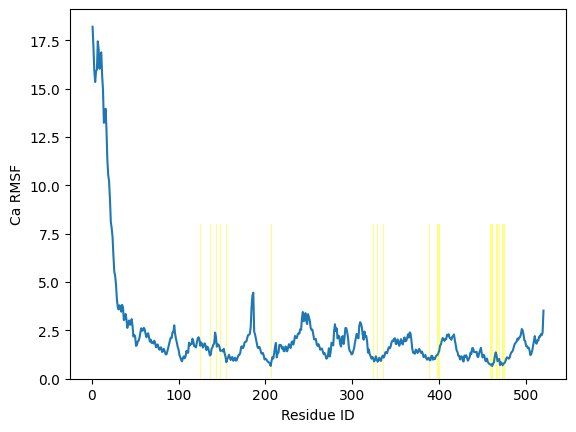

In [ ]:
plt.plot(c_alphas.resids,c_alpha_rmsf.results.rmsf)
plt.bar(binding_site.resids,8,color='yellow',alpha=0.5)
plt.xlabel('Residue ID')
plt.ylabel('Ca RMSF')

In [ ]:
np.savez('cyp4f11_rmsf.npz',resids=c_alphas.resids, resnames=c_alphas.resnames,rmsfs=c_alpha_rmsf.results.rmsf)

In [ ]:
np.load('cyp4f11_rmsf.npz')['resids']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Multiple trajectory analysis.  Again, ultimately we want to analyze all proteins.

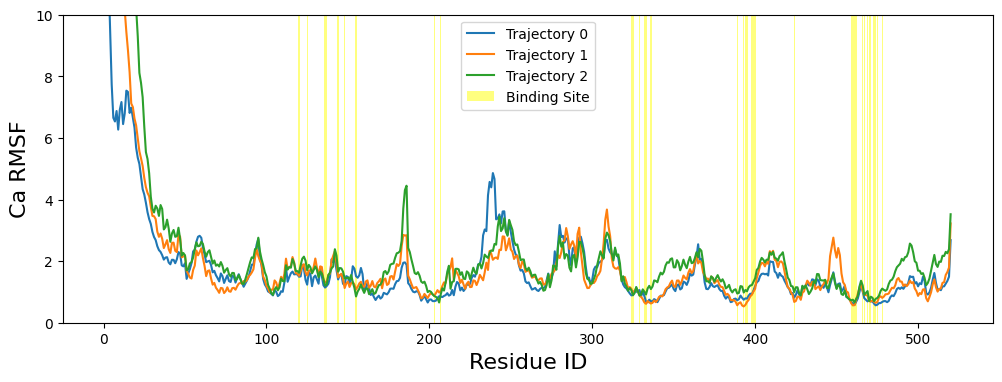

In [ ]:
binding_site = U.select_atoms('protein and name CA and byres around 5 resname HEM')
plt.figure(figsize=(12,4))
plt.bar(binding_site.resids,10,color='yellow',alpha=0.5,label='Binding Site')
plt.ylim(0,10)
for i,u in enumerate(Us):
  c_alphas = u.select_atoms('protein and name CA')
  c_alpha_rmsf = rms.RMSF(c_alphas).run()
  plt.plot(c_alphas.resids,c_alpha_rmsf.results.rmsf,label=f'Trajectory {i}')

plt.legend()
plt.xlabel('Residue ID',fontsize=16)
plt.ylabel('Ca RMSF',fontsize=16)
plt.savefig('carmsf.pdf',bbox_inches='tight',dpi=300)

Calculate the RMSFs of all the atoms and map back onto the structure.

In [ ]:
binding_site.resids

array([120, 125, 136, 137, 144, 148, 155, 203, 207, 324, 325, 329, 332,
       333, 336, 389, 393, 394, 395, 398, 399, 400, 424, 459, 460, 461,
       462, 466, 467, 469, 470, 471, 473, 474, 475, 478])

In [ ]:
notwat = U.select_atoms('not resname WAT')
notwat_rmsf = rms.RMSF(notwat).run()

In [ ]:
U.add_TopologyAttr('tempfactors')

In [ ]:
notwat.tempfactors = notwat_rmsf.results.rmsf

In [ ]:
# have to write out then read in file to get a string
notwat.write('notwat.pdb')
struct = open('notwat.pdb').read()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
v = py3Dmol.view(width=1000,height=800)
v.addModel(struct)
v.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'linear', 'colors': ["blue","yellow","green"],'min':1,'max':3}}})
v.addStyle({'resn':['HEM','CYP','GLG']},{'stick': {'colorscheme':{'prop':'b','gradient':'linear', 'colors': ["blue","yellow","green"],'min':1,'max':4}}})
v.zoomTo({'resn':'HEM'})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol